<a href="https://colab.research.google.com/github/eve-okorie16/sync-ml/blob/main/real_time_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import cv2
import os
import tensorflow.keras
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


In [12]:
# Load the model
model = tensorflow.keras.models.load_model("mask_detector.model", compile=True)

In [13]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


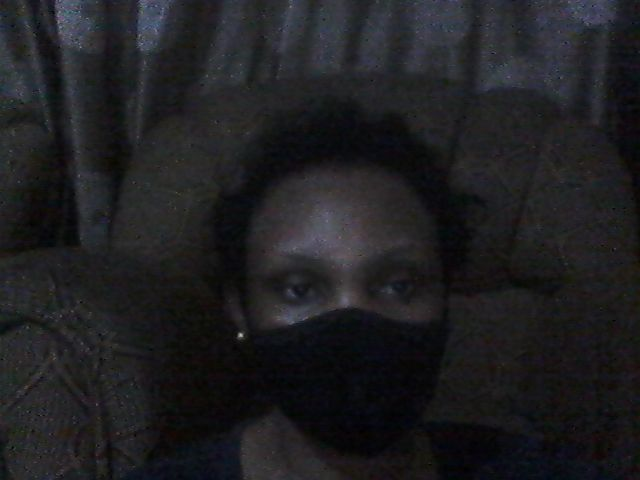

In [14]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<ipython-input-16-3b674795ce47>:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image, size, Image.ANTIALIAS)


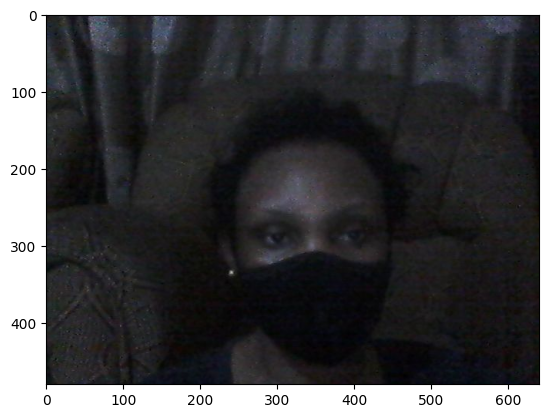

In [16]:
#convert the image to an array
# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

#Change path with your file path
#Just Go to file, right click on file, copy path and paste here
image_path = 'photo.jpg'

# Replace this with the path to your image
image = Image.open(image_path)

normal = plt.imshow(image)

#resize the image to a 224x224 with the same strategy as in TM2:
#resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.ANTIALIAS)

#turn the image into a numpy array
image_array = np.asarray(image)

# display the resized image
#image.show()

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

# Load the image into the array
data[0] = normalized_image_array


In [17]:
# run the inference
pred = model.predict(data)

prediction = pred.argmax(axis=-1)
#print(pred)

label = "Mask On" if prediction == 0 else "No Mask"
label = "{}: {:.2f}%".format(label, max(pred[0]) * 100)
color = (0, 255, 0) if prediction == 0 else (255, 0, 0)

1/1 [==============================] - 1s 1s/step


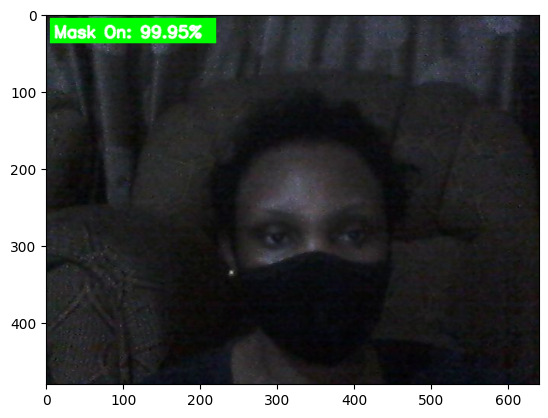

In [18]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread(image_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#print(faces)

im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Creating Box for face
if(len(faces)!=0):
  for (x,y,w,h) in faces:
      cv2.rectangle(im_rgb,(x,y),(x+w,y+h),color, 4)
      #cv2.rectangle(im_rgb, (x,y), (x+w,y-35), color, cv2.FILLED)
      cv2.putText(im_rgb, label, (x+5, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)

else:
  cv2.rectangle(im_rgb, (5, 37), (220, 5), color, cv2.FILLED)
  cv2.putText(im_rgb, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)

#detected Image
detect = plt.imshow(im_rgb)